# 🌍 Napovedovanje emisij CO₂ v Sloveniji in svetu (1950–2036)

V tem projektu analiziramo zgodovinske podatke o emisijah ogljikovega dioksida (CO₂) za Slovenijo in svet ter napovedujemo prihodnje emisije do leta 2036. Uporabljamo različne metode strojnega učenja in časovnih vrst, kot so linearna regresija, Prophet, SARIMAX in eksponentno glajenje (Holt-Winters). Cilj projekta je razumeti trende emisij glede na populacijo, BDP in druge dejavnike ter oceniti prihodnji vpliv na okolje.


## 📥 Uvoz podatkov

Najprej uvozimo podatke iz datoteke `owid-co2-data.csv`, ki vsebuje zgodovinske podatke o emisijah CO₂ za vse države sveta. Podatke preberemo s pomočjo knjižnice `pandas`, kjer kot indeks nastavimo stolpec z imeni držav (`country`).


In [1]:
import pandas as pd

df1 = pd.read_csv('owid-co2-data.csv', index_col='country', sep = ',', decimal='.')
df1.head(3)

,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,co2_including_luc,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1750,AFG,2802560.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,1751,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,1752,AFG,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 🇸🇮 Filtriranje podatkov za Slovenijo

Iz celotnega nabora podatkov izločimo samo podatke, ki se nanašajo na Slovenijo. To storimo z uporabo `.loc[['Slovenia']]`, s čimer dobimo vse vrstice, kjer je država "Slovenia".


In [2]:
df2 = df1.loc[['Slovenia']]
df2.head(3)

,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,co2_including_luc,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
country,,,,,,,,,,,,,,,,,,,,,
Slovenia,1850,SVN,610971.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.189,0.103,NaN,NaN
Slovenia,1851,SVN,616223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.026,0.0,0.0,0.0,0.0,1.214,0.104,NaN,NaN
Slovenia,1852,SVN,621519.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.027,0.0,0.0,0.0,0.0,1.261,0.104,NaN,NaN


## 📅 Filtriranje podatkov po letu

Omejimo podatke za Slovenijo tako, da obdržimo samo podatke od leta 1950 naprej. S tem odstranimo starejše zapise, ki so lahko nepopolni ali nerelevantni za analizo.


In [3]:
df3 = df2[df2['year'] >= 1950]
print(df3.head())

          year iso_code  population           gdp  cement_co2  \
country                                                         
Slovenia  1950      SVN   1446362.0           NaN       0.107   
Slovenia  1951      SVN   1462731.0           NaN       0.102   
Slovenia  1952      SVN   1479671.0  5.859764e+09       0.117   
Slovenia  1953      SVN   1497562.0  6.150275e+09       0.110   
Slovenia  1954      SVN   1515603.0  6.976971e+09       0.121   

          cement_co2_per_capita    co2  co2_growth_abs  co2_growth_prct  \
country                                                                   
Slovenia                  0.074  2.249          -0.092           -3.933   
Slovenia                  0.070  2.129          -0.120           -5.340   
Slovenia                  0.079  2.137           0.008            0.366   
Slovenia                  0.073  2.122          -0.015           -0.688   
Slovenia                  0.080  2.532           0.410           19.335   

          co2_incl

## 📈 Napoved emisij CO₂ za Slovenijo (2026–2036) z linearno regresijo

S pomočjo linearne regresije napovemo skupne emisije CO₂ za obdobje 2026–2036. Uporabimo zgodovinske podatke o prebivalstvu, BDP-ju, emisijah iz cementne industrije in trgovinskem CO₂. Podatke za prihodnost ocenimo z letno rastjo iz zadnjih let, model pa treniramo na očiščenih zgodovinskih podatkih.


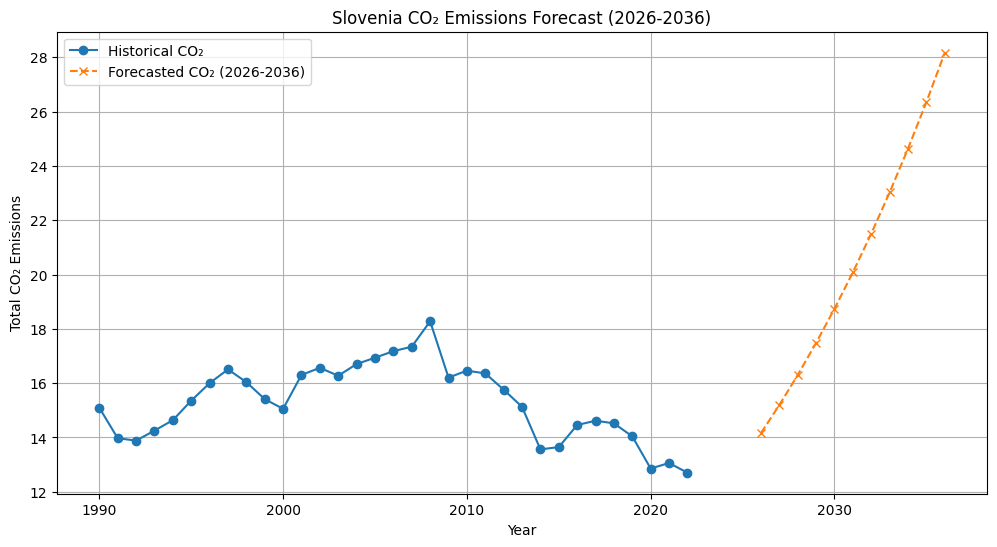

In [4]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# First, drop all rows with any NaNs in df3 relevant columns
df3_clean = df3.dropna(subset=['year', 'population', 'gdp', 'cement_co2', 'trade_co2', 'co2'])

# Define the future forecast range: 2026 to 2036
future_years = np.arange(2026, 2037)  # 11 years total

# Calculate annual growth rates for population and GDP from the last two years in cleaned data
pop_growth_rate = (df3_clean['population'].iloc[-1] - df3_clean['population'].iloc[-2]) / df3_clean['population'].iloc[-2]
gdp_growth_rate = (df3_clean['gdp'].iloc[-1] - df3_clean['gdp'].iloc[-2]) / df3_clean['gdp'].iloc[-2]

# Extrapolate population and GDP values for 2026-2036 using compound growth
future_population = [df3_clean['population'].iloc[-1] * ((1 + pop_growth_rate) ** i) for i in range(1, len(future_years) + 1)]
future_gdp = [df3_clean['gdp'].iloc[-1] * ((1 + gdp_growth_rate) ** i) for i in range(1, len(future_years) + 1)]

# Use the last known values of cement_co2 and trade_co2 as constants (or you can model them)
future_cement_co2 = [df3_clean['cement_co2'].iloc[-1]] * len(future_years)
future_trade_co2 = [df3_clean['trade_co2'].iloc[-1]] * len(future_years)

# Create future DataFrame
future_df = pd.DataFrame({
    'year': future_years,
    'population': future_population,
    'gdp': future_gdp,
    'cement_co2': future_cement_co2,
    'trade_co2': future_trade_co2
})

# Define features and target from cleaned historical data
X = df3_clean[['year', 'population', 'gdp', 'cement_co2', 'trade_co2']]
y = df3_clean['co2']

# Train the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict future CO2 emissions
future_df['co2_predicted'] = model.predict(future_df[['year', 'population', 'gdp', 'cement_co2', 'trade_co2']])

# Plot historical and forecasted CO2 emissions
plt.figure(figsize=(12, 6))
plt.plot(df3_clean['year'], y, marker='o', label='Historical CO₂')
plt.plot(future_df['year'], future_df['co2_predicted'], marker='x', linestyle='--', label='Forecasted CO₂ (2026-2036)')
plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions')
plt.title('Slovenia CO₂ Emissions Forecast (2026-2036)')
plt.legend()
plt.grid(True)
plt.show()


## 🌳 Napoved emisij CO₂ za Slovenijo z uporabo naključnega gozda (Random Forest)

V tem modelu za napoved emisij CO₂ med leti 2026–2036 uporabimo metodo naključnega gozda (Random Forest Regressor). Model temelji na zgodovinskih podatkih o prebivalstvu, BDP-ju, emisijah iz cementne industrije in trgovini. Za prihodnost predpostavimo konstantno rast prebivalstva in BDP ter ohranimo zadnje izmerjene vrednosti za cementni in trgovinski CO₂.


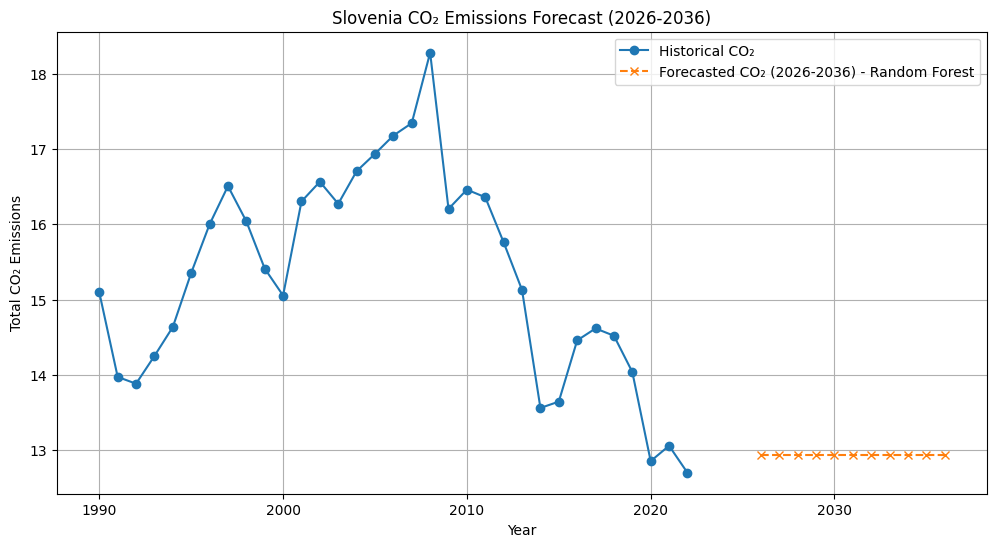

In [5]:
from sklearn.ensemble import RandomForestRegressor

# Drop rows with NaNs in relevant columns
df3_clean = df3.dropna(subset=['year', 'population', 'gdp', 'cement_co2', 'trade_co2', 'co2'])

# Define the future forecast range: 2026 to 2036
future_years = np.arange(2026, 2037)  # 11 years total

# Calculate annual growth rates for population and GDP from last two years
pop_growth_rate = (df3_clean['population'].iloc[-1] - df3_clean['population'].iloc[-2]) / df3_clean['population'].iloc[-2]
gdp_growth_rate = (df3_clean['gdp'].iloc[-1] - df3_clean['gdp'].iloc[-2]) / df3_clean['gdp'].iloc[-2]

# Extrapolate population and GDP values for future years
future_population = [df3_clean['population'].iloc[-1] * ((1 + pop_growth_rate) ** i) for i in range(1, len(future_years) + 1)]
future_gdp = [df3_clean['gdp'].iloc[-1] * ((1 + gdp_growth_rate) ** i) for i in range(1, len(future_years) + 1)]

# Use last known cement_co2 and trade_co2 as constants
future_cement_co2 = [df3_clean['cement_co2'].iloc[-1]] * len(future_years)
future_trade_co2 = [df3_clean['trade_co2'].iloc[-1]] * len(future_years)

# Create future dataframe
future_df = pd.DataFrame({
    'year': future_years,
    'population': future_population,
    'gdp': future_gdp,
    'cement_co2': future_cement_co2,
    'trade_co2': future_trade_co2
})

# Prepare training data
X = df3_clean[['year', 'population', 'gdp', 'cement_co2', 'trade_co2']]
y = df3_clean['co2']

# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Predict future CO2 emissions
future_df['co2_predicted'] = rf_model.predict(future_df[['year', 'population', 'gdp', 'cement_co2', 'trade_co2']])

# Plot historical and forecasted CO2 emissions
plt.figure(figsize=(12, 6))
plt.plot(df3_clean['year'], y, marker='o', label='Historical CO₂')
plt.plot(future_df['year'], future_df['co2_predicted'], marker='x', linestyle='--', label='Forecasted CO₂ (2026-2036) - Random Forest')
plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions')
plt.title('Slovenia CO₂ Emissions Forecast (2026-2036)')
plt.legend()
plt.grid(True)
plt.show()


## 📈 Napoved emisij CO₂ za Slovenijo z uporabo modela Prophet

Model Prophet, razvit pri Facebooku, se uporablja za napovedovanje časovnih vrst. Tukaj z njim napovemo emisije CO₂ v Sloveniji od leta 2026 do 2036, na podlagi zgodovinskih podatkov od leta 1950 dalje. Model pričakuje stolpca `ds` (datum) in `y` (ciljna spremenljivka – CO₂), zato leto pretvorimo v obliko datuma. Uporabimo le dolgoročni trend, brez sezonskih nihanj.


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1xrd6lfh/70jsqcot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1xrd6lfh/bkip_gf1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2852', 'data', 'file=/tmp/tmp1xrd6lfh/70jsqcot.json', 'init=/tmp/tmp1xrd6lfh/bkip_gf1.json', 'output', 'file=/tmp/tmp1xrd6lfh/prophet_modelw9e5tbc7/prophet_model-20250605202911.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:29:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:29:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


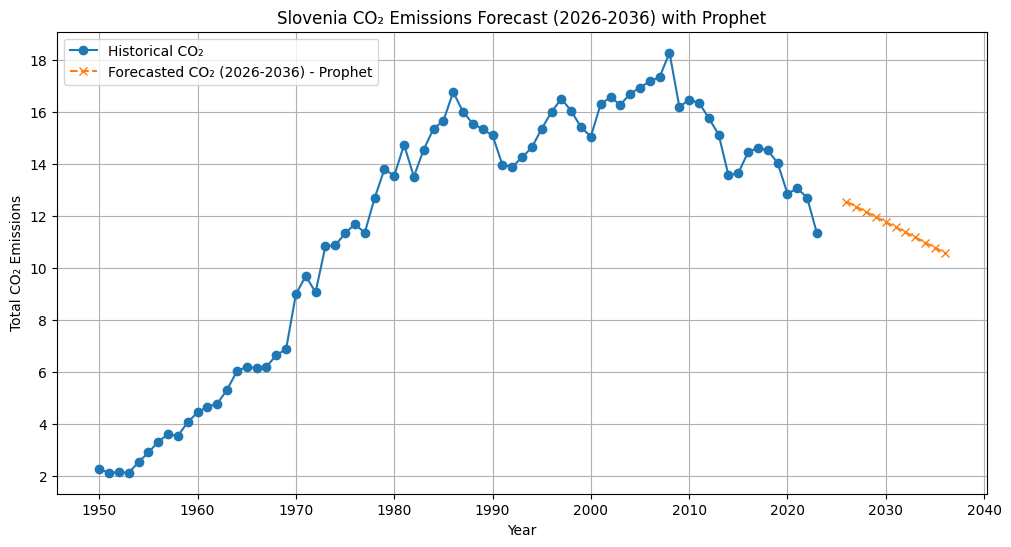

In [6]:
from prophet import Prophet

# Prepare data for Prophet: needs 'ds' (date) and 'y' (target) columns
df3_clean = df3.dropna(subset=['year', 'co2']).copy()

# Prophet expects datetime, so convert year to datetime (just Jan 1 of each year)
df3_clean['ds'] = pd.to_datetime(df3_clean['year'], format='%Y')

# Target variable
df3_clean['y'] = df3_clean['co2']

# Prepare dataframe with only needed columns
df_prophet = df3_clean[['ds', 'y']]

# Initialize and fit Prophet model
model = Prophet(yearly_seasonality=False)  # yearly_seasonality=False since annual data
model.fit(df_prophet)

# Create dataframe for future years (2026-2036)
future_years = pd.date_range(start='2026-01-01', end='2036-01-01', freq='YS')  # Year start freq
future = pd.DataFrame({'ds': future_years})

# Predict future CO2 emissions
forecast = model.predict(future)

# Plot historical and forecasted data
plt.figure(figsize=(12,6))
plt.plot(df_prophet['ds'], df_prophet['y'], marker='o', label='Historical CO₂')
plt.plot(forecast['ds'], forecast['yhat'], marker='x', linestyle='--', label='Forecasted CO₂ (2026-2036) - Prophet')
plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions')
plt.title('Slovenia CO₂ Emissions Forecast (2026-2036) with Prophet')
plt.legend()
plt.grid(True)
plt.show()


## 📉 Napoved emisij CO₂ z upoštevanjem motenj (kriza 2008, COVID-19)

V tej napovedi z modelom Prophet vključimo dva pomembna motilna dogodka – **gospodarsko krizo leta 2008** in **pandemijo COVID-19 leta 2020**. Uporabimo jih kot t.i. `holidays`, kar omogoča modelu, da upošteva njihov vpliv na trende emisij CO₂. Vsak dogodek pokriva leto nastanka in morebitne kratkoročne posledice (1 leto).


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1xrd6lfh/z15xiet1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1xrd6lfh/e56pq9m0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57612', 'data', 'file=/tmp/tmp1xrd6lfh/z15xiet1.json', 'init=/tmp/tmp1xrd6lfh/e56pq9m0.json', 'output', 'file=/tmp/tmp1xrd6lfh/prophet_modelc5gc_fwn/prophet_model-20250605202914.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:29:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:29:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


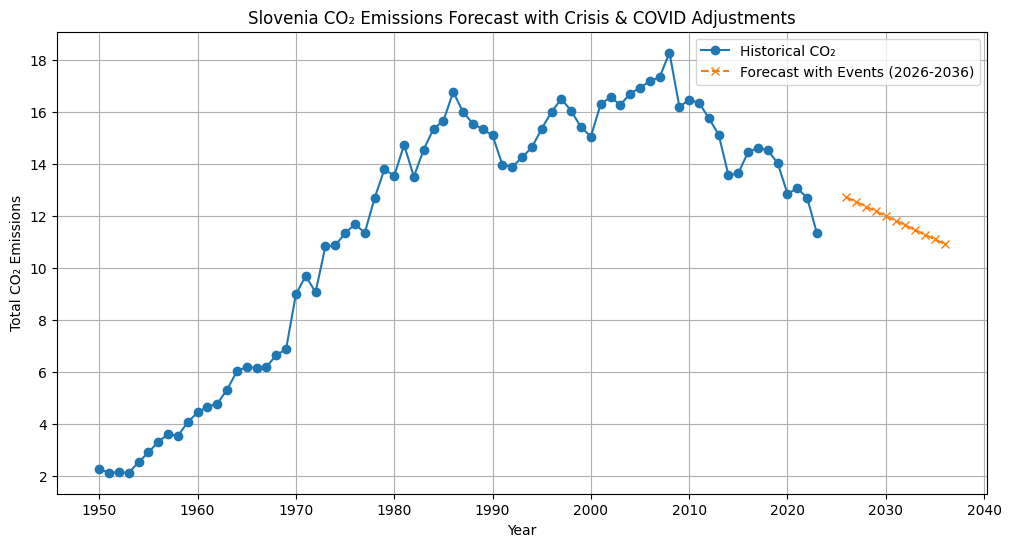

In [7]:
# Prepare data as before
df3_clean = df3.dropna(subset=['year', 'co2']).copy()
df3_clean['ds'] = pd.to_datetime(df3_clean['year'], format='%Y')
df3_clean['y'] = df3_clean['co2']
df_prophet = df3_clean[['ds', 'y']]

# Define major disruptive events
events = pd.DataFrame({
    'holiday': ['economic_crisis_2008', 'covid_2020'],
    'ds': pd.to_datetime(['2008-01-01', '2020-01-01']),
    'lower_window': 0,
    'upper_window': 1  # can cover 1 year after event
})

# Initialize Prophet with holidays
model = Prophet(holidays=events, yearly_seasonality=False)
model.fit(df_prophet)

# Forecast future years
future_years = pd.date_range(start='2026-01-01', end='2036-01-01', freq='YS')
future = pd.DataFrame({'ds': future_years})

forecast = model.predict(future)

# Plot results
plt.figure(figsize=(12,6))
plt.plot(df_prophet['ds'], df_prophet['y'], marker='o', label='Historical CO₂')
plt.plot(forecast['ds'], forecast['yhat'], marker='x', linestyle='--', label='Forecast with Events (2026-2036)')
plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions')
plt.title('Slovenia CO₂ Emissions Forecast with Crisis & COVID Adjustments')
plt.legend()
plt.grid(True)
plt.show()


## 🤖 Napoved emisij CO₂ z več regresijskimi modeli (2026–2036)

V tem delu uporabimo več različnih modelov strojnega učenja za napovedovanje emisij CO₂ v Sloveniji:
- **Gradient Boosting Regressor** (gradientno ojačanje),
- **Support Vector Regressor** (podporni vektorji),
- **Decision Tree Regressor** (odločitveno drevo).

Modeli so trenirani na zgodovinskih podatkih, nato pa uporabimo ocenjene letne rasti za **prebivalstvo** in **BDP**, medtem ko cementni in trgovinski CO₂ ohranimo konstantna. Napovedi prikazujemo za obdobje **2026–2036**.


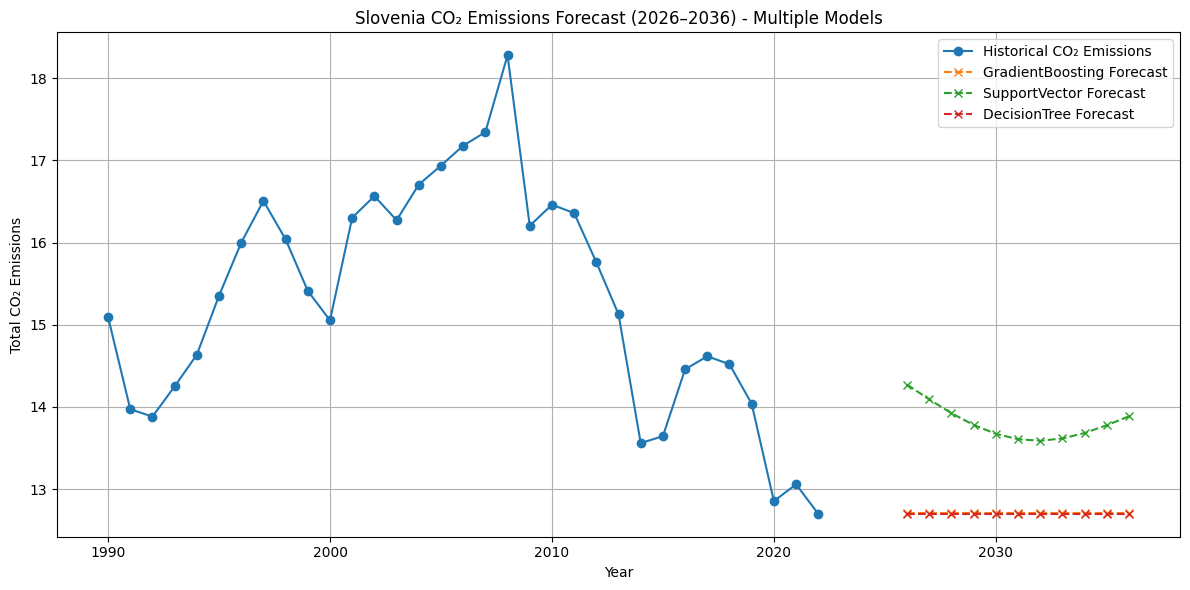

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Drop rows with NaNs
df3_clean = df3.dropna(subset=['year', 'population', 'gdp', 'cement_co2', 'trade_co2', 'co2']).copy()

# Prepare features and target
X = df3_clean[['year', 'population', 'gdp', 'cement_co2', 'trade_co2']]
y = df3_clean['co2']

# Forecast for years 2026–2036
future_years = np.arange(2026, 2037)

# Estimate growth rates
pop_growth_rate = (df3_clean['population'].iloc[-1] - df3_clean['population'].iloc[-2]) / df3_clean['population'].iloc[-2]
gdp_growth_rate = (df3_clean['gdp'].iloc[-1] - df3_clean['gdp'].iloc[-2]) / df3_clean['gdp'].iloc[-2]

# Project future features
future_population = [df3_clean['population'].iloc[-1] * ((1 + pop_growth_rate) ** i) for i in range(1, len(future_years) + 1)]
future_gdp = [df3_clean['gdp'].iloc[-1] * ((1 + gdp_growth_rate) ** i) for i in range(1, len(future_years) + 1)]
future_cement_co2 = [df3_clean['cement_co2'].iloc[-1]] * len(future_years)
future_trade_co2 = [df3_clean['trade_co2'].iloc[-1]] * len(future_years)

future_df = pd.DataFrame({
    'year': future_years,
    'population': future_population,
    'gdp': future_gdp,
    'cement_co2': future_cement_co2,
    'trade_co2': future_trade_co2
})

# Define models
models = {
    'GradientBoosting': GradientBoostingRegressor(),
    'SupportVector': SVR(),
    'DecisionTree': DecisionTreeRegressor()
}

# Store predictions
predictions = {}

# Train and forecast
for name, model in models.items():
    model.fit(X, y)
    y_pred = model.predict(future_df[['year', 'population', 'gdp', 'cement_co2', 'trade_co2']])
    predictions[name] = y_pred

# Plot historical and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df3_clean['year'], y, marker='o', label='Historical CO₂ Emissions')

for name, y_pred in predictions.items():
    plt.plot(future_years, y_pred, marker='x', linestyle='--', label=f'{name} Forecast')

plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions')
plt.title('Slovenia CO₂ Emissions Forecast (2026–2036) - Multiple Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔍 Napoved emisij CO₂ s K-Nearest Neighbors (KNN) modelom (2026–2036)

Uporabljamo KNN regresor z 3 najbližjimi sosedi za napoved emisij CO₂ v Sloveniji. Model temelji na zgodovinskih podatkih, prihodnje vrednosti pa izračunamo na podlagi ocenjenih stopenj rasti prebivalstva in BDP, medtem ko cementni in trgovinski CO₂ držimo konstantna. Prikazane so napovedi za obdobje 2026–2036.


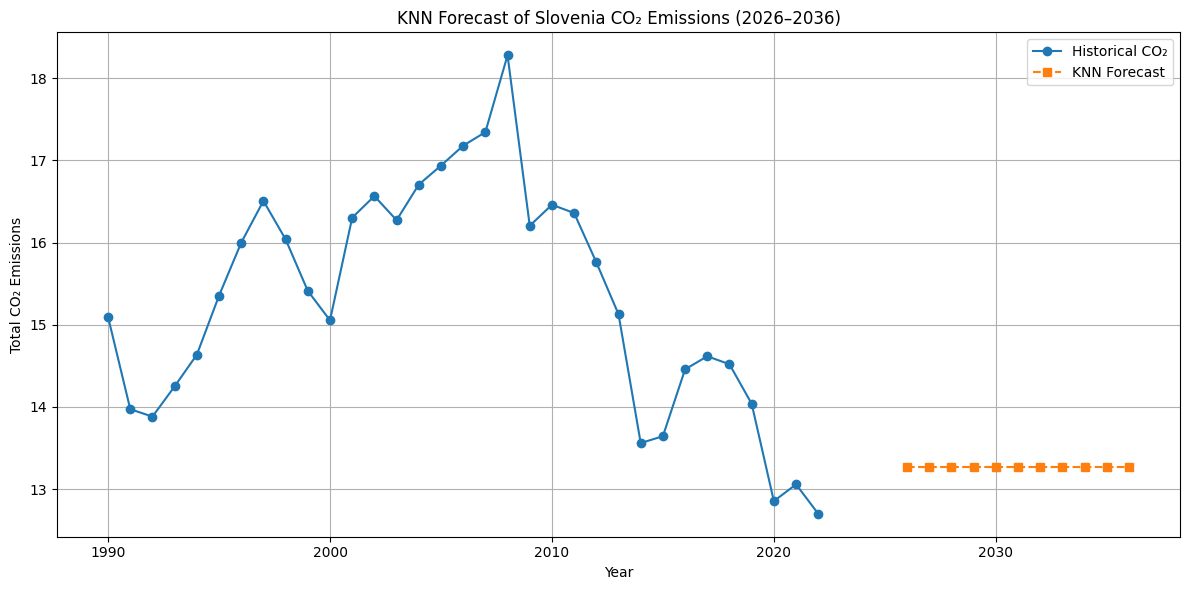

In [9]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np

# Drop NaNs
df3_clean = df3.dropna(subset=['year', 'population', 'gdp', 'cement_co2', 'trade_co2', 'co2']).copy()

# Features and target
X = df3_clean[['year', 'population', 'gdp', 'cement_co2', 'trade_co2']]
y = df3_clean['co2']

# Forecast years
future_years = np.arange(2026, 2037)

# Growth rates
pop_growth_rate = (df3_clean['population'].iloc[-1] - df3_clean['population'].iloc[-2]) / df3_clean['population'].iloc[-2]
gdp_growth_rate = (df3_clean['gdp'].iloc[-1] - df3_clean['gdp'].iloc[-2]) / df3_clean['gdp'].iloc[-2]

# Future features
future_population = [df3_clean['population'].iloc[-1] * ((1 + pop_growth_rate) ** i) for i in range(1, len(future_years) + 1)]
future_gdp = [df3_clean['gdp'].iloc[-1] * ((1 + gdp_growth_rate) ** i) for i in range(1, len(future_years) + 1)]
future_cement_co2 = [df3_clean['cement_co2'].iloc[-1]] * len(future_years)
future_trade_co2 = [df3_clean['trade_co2'].iloc[-1]] * len(future_years)

future_df = pd.DataFrame({
    'year': future_years,
    'population': future_population,
    'gdp': future_gdp,
    'cement_co2': future_cement_co2,
    'trade_co2': future_trade_co2
})

# KNN Model
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(X, y)
knn_predictions = knn_model.predict(future_df[['year', 'population', 'gdp', 'cement_co2', 'trade_co2']])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df3_clean['year'], y, marker='o', label='Historical CO₂')
plt.plot(future_years, knn_predictions, marker='s', linestyle='--', label='KNN Forecast')
plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions')
plt.title('KNN Forecast of Slovenia CO₂ Emissions (2026–2036)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔍 Napoved emisij CO₂ s Gradient Boosting regresorjem (2026–2036)

Uporabljamo Gradient Boosting regresor za napoved emisij CO₂ v Sloveniji v obdobju 2026–2036. Model temelji na zgodovinskih podatkih o letu, prebivalstvu, BDP, emisijah cementa in trgovine. Prihodnje vrednosti prebivalstva in BDP so izračunane na podlagi ocenjenih stopenj rasti, emisije cementa in trgovine pa so obravnavane kot konstantne.


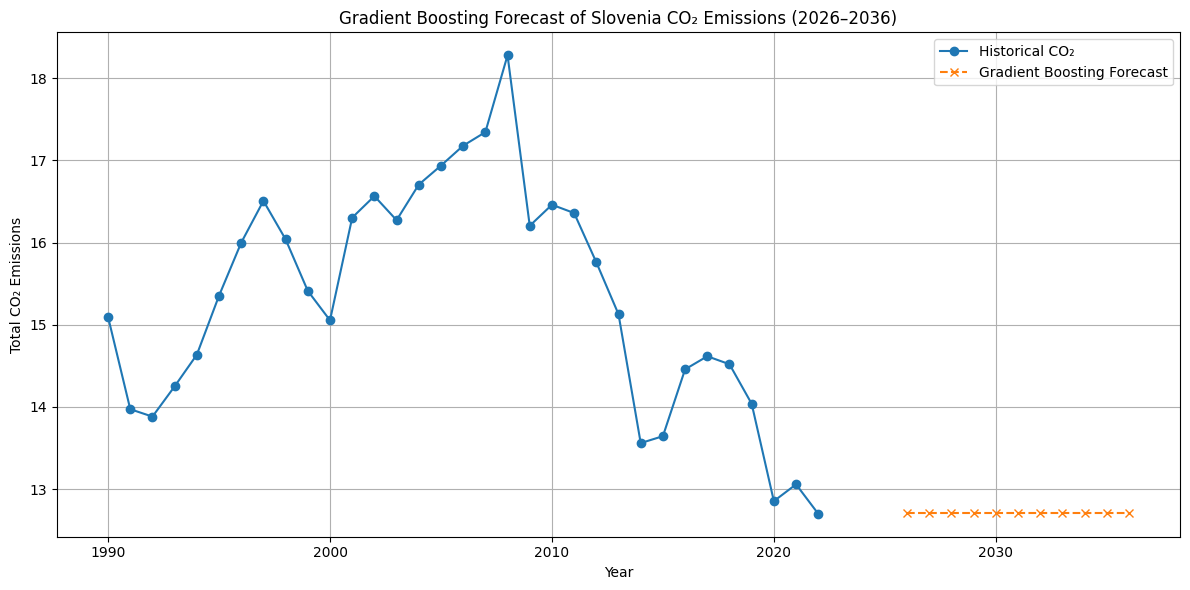

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import numpy as np

# Drop NaNs
df3_clean = df3.dropna(subset=['year', 'population', 'gdp', 'cement_co2', 'trade_co2', 'co2']).copy()

# Features and target
X = df3_clean[['year', 'population', 'gdp', 'cement_co2', 'trade_co2']]
y = df3_clean['co2']

# Forecast years
future_years = np.arange(2026, 2037)

# Growth rates
pop_growth_rate = (df3_clean['population'].iloc[-1] - df3_clean['population'].iloc[-2]) / df3_clean['population'].iloc[-2]
gdp_growth_rate = (df3_clean['gdp'].iloc[-1] - df3_clean['gdp'].iloc[-2]) / df3_clean['gdp'].iloc[-2]

# Future features
future_population = [df3_clean['population'].iloc[-1] * ((1 + pop_growth_rate) ** i) for i in range(1, len(future_years) + 1)]
future_gdp = [df3_clean['gdp'].iloc[-1] * ((1 + gdp_growth_rate) ** i) for i in range(1, len(future_years) + 1)]
future_cement_co2 = [df3_clean['cement_co2'].iloc[-1]] * len(future_years)
future_trade_co2 = [df3_clean['trade_co2'].iloc[-1]] * len(future_years)

future_df = pd.DataFrame({
    'year': future_years,
    'population': future_population,
    'gdp': future_gdp,
    'cement_co2': future_cement_co2,
    'trade_co2': future_trade_co2
})

# Gradient Boosting Model
gb_model = GradientBoostingRegressor()
gb_model.fit(X, y)
gb_predictions = gb_model.predict(future_df[['year', 'population', 'gdp', 'cement_co2', 'trade_co2']])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df3_clean['year'], y, marker='o', label='Historical CO₂')
plt.plot(future_years, gb_predictions, marker='x', linestyle='--', label='Gradient Boosting Forecast')
plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions')
plt.title('Gradient Boosting Forecast of Slovenia CO₂ Emissions (2026–2036)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 📈 Napoved emisij CO₂ s SARIMAX modelom (2026–2036)

Za napoved emisij CO₂ v Sloveniji smo uporabili SARIMAX model, ki upošteva časovne vrstice podatkov z upoštevanjem avtokorelacije in morebitnih sezonskih učinkov (v tem primeru brez sezonskosti). Model smo naučili na zgodovinskih povprečnih letnih emisijah in z njim napovedali emisije za obdobje 2026–2036.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-i

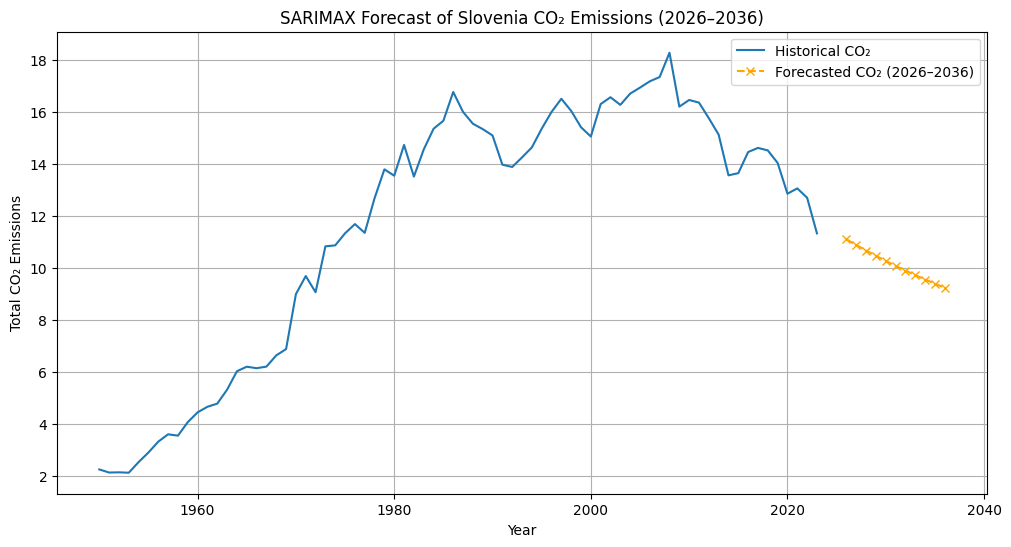

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Prepare the data
df_ts = df3[['year', 'co2']].dropna().copy()
df_ts = df_ts.groupby('year')['co2'].mean().reset_index()
df_ts.set_index('year', inplace=True)

# Fit SARIMAX model (order can be tuned, this is a basic setup)
model = sm.tsa.SARIMAX(df_ts, order=(1,1,1), seasonal_order=(0,0,0,0))
results = model.fit()

# Forecast 11 years ahead (2026–2036)
forecast = results.get_forecast(steps=11)
forecast_years = list(range(2026, 2037))
forecast_values = forecast.predicted_mean

# Plot
plt.figure(figsize=(12,6))
plt.plot(df_ts.index, df_ts['co2'], label='Historical CO₂')
plt.plot(forecast_years, forecast_values, marker='x', linestyle='--', label='Forecasted CO₂ (2026–2036)', color='orange')
plt.xlabel("Year")
plt.ylabel("Total CO₂ Emissions")
plt.title("SARIMAX Forecast of Slovenia CO₂ Emissions (2026–2036)")
plt.grid(True)
plt.legend()
plt.show()


## 🌿 Napoved emisij CO₂ s Holt-Winters eksponentnim glajenjem (2026–2036)

Uporabili smo eksponentno glajenje z aditivnim trendom za napoved emisij CO₂ v Sloveniji. Model brez sezonskosti napoveduje trend v obdobju 2026–2036 na podlagi zgodovinskih podatkov.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


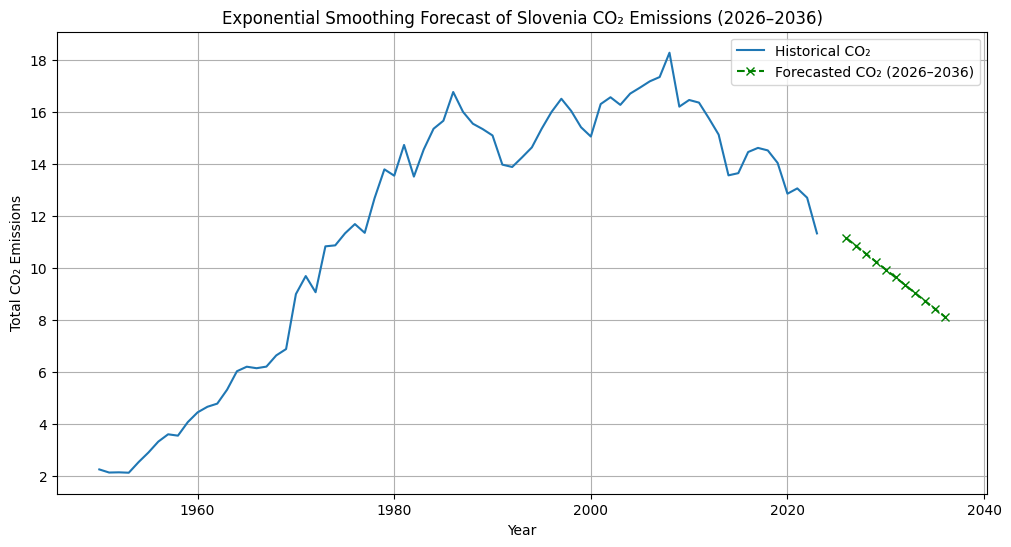

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Prepare the data
df_hw = df3[['year', 'co2']].dropna().copy()
df_hw = df_hw.groupby('year')['co2'].mean().reset_index()
df_hw.set_index('year', inplace=True)

# Fit the model (no seasonality, just trend)
model = ExponentialSmoothing(df_hw['co2'], trend='add', seasonal=None)
fit = model.fit()

# Forecast 11 years ahead (2026–2036)
forecast = fit.forecast(steps=11)
forecast_years = list(range(2026, 2037))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df_hw.index, df_hw['co2'], label='Historical CO₂')
plt.plot(forecast_years, forecast, marker='x', linestyle='--', color='green', label='Forecasted CO₂ (2026–2036)')
plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions')
plt.title("Exponential Smoothing Forecast of Slovenia CO₂ Emissions (2026–2036)")
plt.grid(True)
plt.legend()
plt.show()


## 🌍 Izbor podatkov za svetovni nivo

Iz izvirnega DataFrame `df1` izberemo samo vrstico z indeksom `'World'`.  
Uporaba `.loc[['World']]` nam zagotovi, da dobimo rezultat kot DataFrame (in ne Series), kar olajša nadaljnjo obdelavo.  

Prikaz prvih treh vrstic novega DataFrame `df5` za hiter pregled podatkov.


In [13]:
df5 = df1.loc[['World']]
df5.head(3)

,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,co2_including_luc,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
country,,,,,,,,,,,,,,,,,,,,,
World,1750,NaN,753279296.0,NaN,NaN,NaN,9.306,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
World,1751,NaN,NaN,NaN,NaN,NaN,9.407,0.101,1.088,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
World,1752,NaN,NaN,NaN,NaN,NaN,9.505,0.098,1.041,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 📅 Filtriranje podatkov od leta 1950 naprej

Iz DataFrame `df5` izberemo samo vrstice, kjer je vrednost v stolpcu `'year'` večja ali enaka 1950.  
To nam omogoča, da se osredotočimo na podatke iz novejšega obdobja, kar je pogosto relevantno za analize in vizualizacije.

Nato izpišemo prvih 5 vrstic filtriranega DataFrame `df6` za hitro preverjanje.


In [14]:
df6 = df5[df5['year'] >= 1950]
print(df6.head())

         year iso_code    population           gdp  cement_co2  \
country                                                          
World    1950      NaN  2.493093e+09  8.461552e+12      66.900   
World    1951      NaN  2.536927e+09           NaN      75.766   
World    1952      NaN  2.584086e+09           NaN      80.746   
World    1953      NaN  2.634106e+09           NaN      89.546   
World    1954      NaN  2.685895e+09           NaN      97.134   

         cement_co2_per_capita       co2  co2_growth_abs  co2_growth_prct  \
country                                                                     
World                    0.027  5930.244         726.208           13.955   
World                    0.030  6381.429         451.185            7.608   
World                    0.031  6467.460          86.032            1.348   
World                    0.034  6650.885         183.425            2.836   
World                    0.036  6789.529         138.644            2.085  

## 📈 Napoved emisij CO₂ z linearno regresijo (2026–2036)

V tej analizi napovedujemo skupne emisije CO₂ za obdobje 2026–2036 z uporabo linearne regresije. Model upošteva več vhodnih spremenljivk: leto, populacijo, BDP ter emisije CO₂ iz cementarne in trgovine.

Podatki so očiščeni manjkajočih vrednosti in napoved izvedemo na podlagi trenda iz preteklih let.


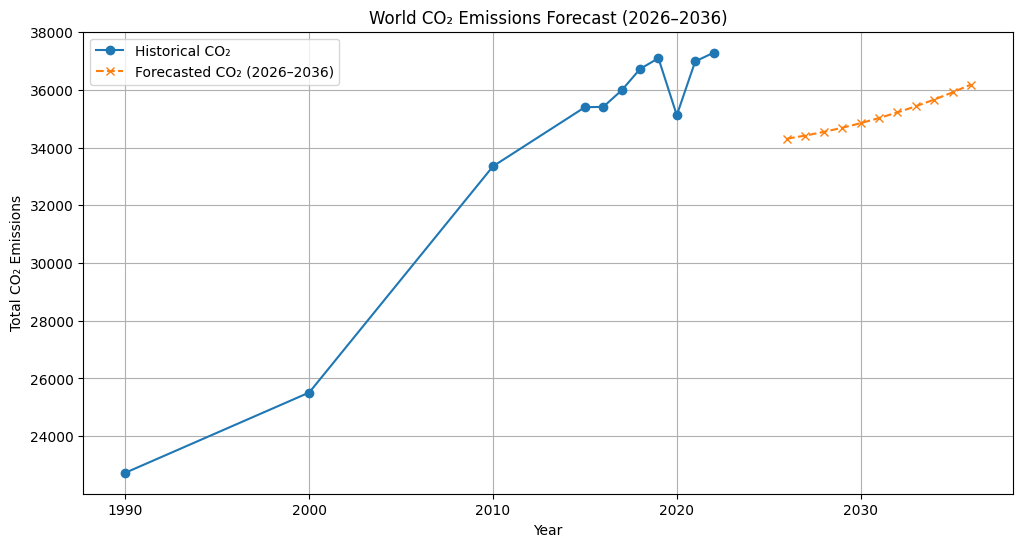

In [15]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Clean NaNs
df6_clean = df6.dropna(subset=['year', 'population', 'gdp', 'cement_co2', 'trade_co2', 'co2'])

# Forecast years
future_years = np.arange(2026, 2037)

# Growth rates
pop_growth_rate = (df6_clean['population'].iloc[-1] - df6_clean['population'].iloc[-2]) / df6_clean['population'].iloc[-2]
gdp_growth_rate = (df6_clean['gdp'].iloc[-1] - df6_clean['gdp'].iloc[-2]) / df6_clean['gdp'].iloc[-2]

# Extrapolate
future_population = [df6_clean['population'].iloc[-1] * ((1 + pop_growth_rate) ** i) for i in range(1, len(future_years) + 1)]
future_gdp = [df6_clean['gdp'].iloc[-1] * ((1 + gdp_growth_rate) ** i) for i in range(1, len(future_years) + 1)]
future_cement_co2 = [df6_clean['cement_co2'].iloc[-1]] * len(future_years)
future_trade_co2 = [df6_clean['trade_co2'].iloc[-1]] * len(future_years)

# Future DataFrame
future_df = pd.DataFrame({
    'year': future_years,
    'population': future_population,
    'gdp': future_gdp,
    'cement_co2': future_cement_co2,
    'trade_co2': future_trade_co2
})

# Train model
X = df6_clean[['year', 'population', 'gdp', 'cement_co2', 'trade_co2']]
y = df6_clean['co2']
model = LinearRegression()
model.fit(X, y)

# Predict
future_df['co2_predicted'] = model.predict(future_df[['year', 'population', 'gdp', 'cement_co2', 'trade_co2']])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df6_clean['year'], y, marker='o', label='Historical CO₂')
plt.plot(future_df['year'], future_df['co2_predicted'], marker='x', linestyle='--', label='Forecasted CO₂ (2026–2036)')
plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions')
plt.title('World CO₂ Emissions Forecast (2026–2036)')
plt.legend()
plt.grid(True)
plt.show()


## 🔮 Napoved emisij CO₂ z modelom Prophet (2026–2036)

Za napoved emisij CO₂ uporabimo model Prophet, ki omogoča fleksibilno modeliranje trendov brez sezonskosti.

Podatke pripravimo tako, da spremenimo leto v format, ki ga Prophet pričakuje (`ds`), ter uporabimo skupne emisije CO₂ kot ciljno spremenljivko (`y`). Napoved izvedemo za obdobje 2026–2036.


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1xrd6lfh/hfz6_h7e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1xrd6lfh/rhcwon5e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46005', 'data', 'file=/tmp/tmp1xrd6lfh/hfz6_h7e.json', 'init=/tmp/tmp1xrd6lfh/rhcwon5e.json', 'output', 'file=/tmp/tmp1xrd6lfh/prophet_model48smvn_w/prophet_model-20250605202954.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:29:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:29:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


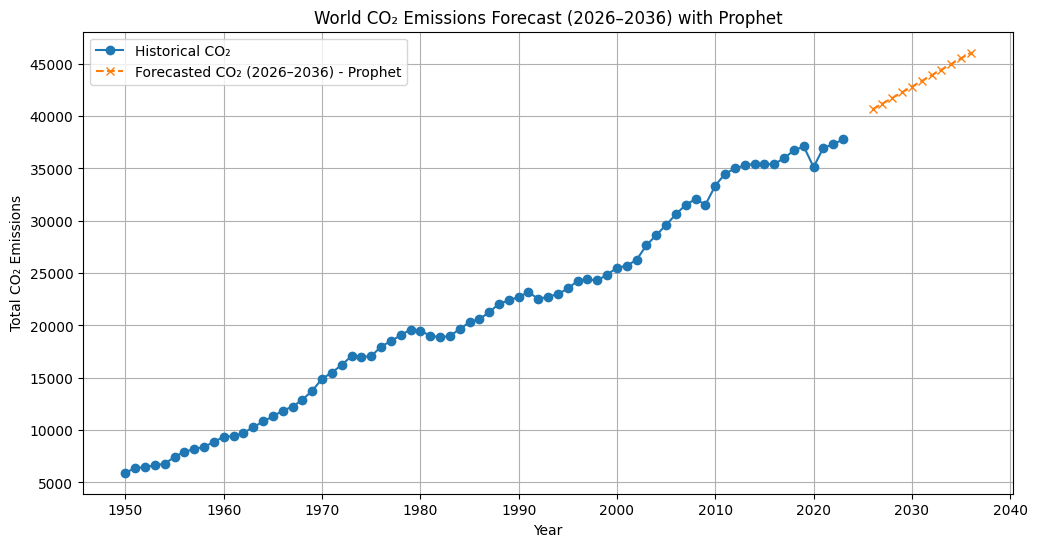

In [16]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Clean and format
df6_clean = df6.dropna(subset=['year', 'co2']).copy()
df6_clean['ds'] = pd.to_datetime(df6_clean['year'], format='%Y')
df6_clean['y'] = df6_clean['co2']
df_prophet = df6_clean[['ds', 'y']]

# Fit model
model = Prophet(yearly_seasonality=False)
model.fit(df_prophet)

# Future DataFrame
future = pd.DataFrame({'ds': pd.date_range(start='2026-01-01', end='2036-01-01', freq='YS')})
forecast = model.predict(future)

# Plot
plt.figure(figsize=(12,6))
plt.plot(df_prophet['ds'], df_prophet['y'], marker='o', label='Historical CO₂')
plt.plot(forecast['ds'], forecast['yhat'], marker='x', linestyle='--', label='Forecasted CO₂ (2026–2036) - Prophet')
plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions')
plt.title('World CO₂ Emissions Forecast (2026–2036) with Prophet')
plt.legend()
plt.grid(True)
plt.show()


## 📊 Napoved emisij CO₂ z modelom SARIMAX (2026–2036)

Za napoved skupnih emisij CO₂ uporabimo časovni model SARIMAX, ki omogoča modeliranje avtokorelacije in trendov v podatkih.

Podatke uredimo tako, da združimo emisije po letih, nato pa model prilagodimo in napovemo vrednosti za obdobje 2026–2036.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning

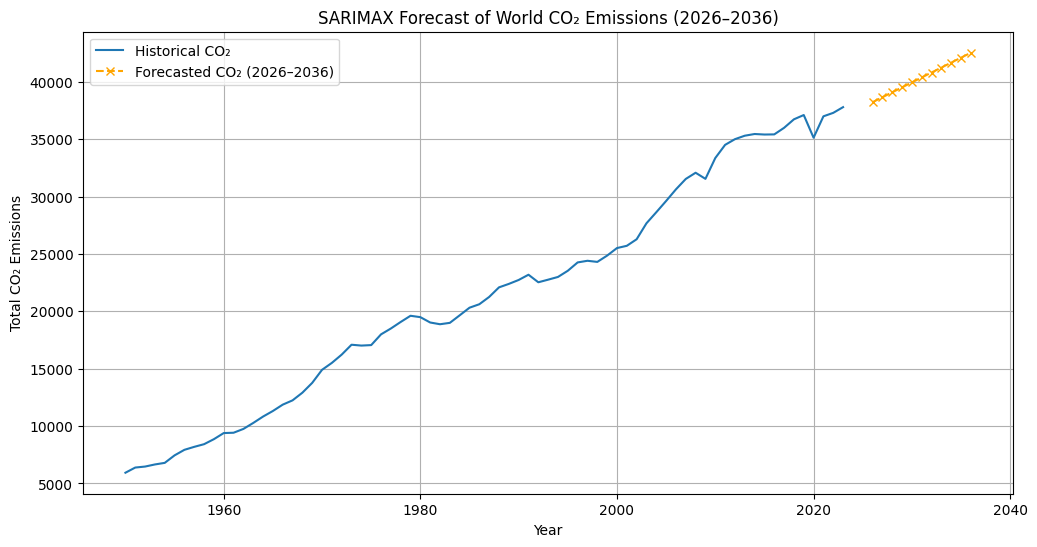

In [17]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Clean and set index
df_ts = df6[['year', 'co2']].dropna().copy()
df_ts = df_ts.groupby('year')['co2'].mean().reset_index()
df_ts.set_index('year', inplace=True)

# Fit SARIMAX
model = sm.tsa.SARIMAX(df_ts, order=(1,1,1), seasonal_order=(0,0,0,0))
results = model.fit()

# Forecast
forecast = results.get_forecast(steps=11)
forecast_years = list(range(2026, 2037))
forecast_values = forecast.predicted_mean

# Plot
plt.figure(figsize=(12,6))
plt.plot(df_ts.index, df_ts['co2'], label='Historical CO₂')
plt.plot(forecast_years, forecast_values, marker='x', linestyle='--', color='orange', label='Forecasted CO₂ (2026–2036)')
plt.xlabel("Year")
plt.ylabel("Total CO₂ Emissions")
plt.title("SARIMAX Forecast of World CO₂ Emissions (2026–2036)")
plt.grid(True)
plt.legend()
plt.show()


## 🌿 Napoved emisij CO₂ z eksponentnim glajenjem Holt-Winters (2026–2036)

Za napoved emisij CO₂ uporabimo Holt-Winters eksponentno glajenje z aditivnim trendom, brez sezonskosti. Model temelji na zgodovinskih podatkih o emisijah in napove trend v obdobju 2026–2036.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


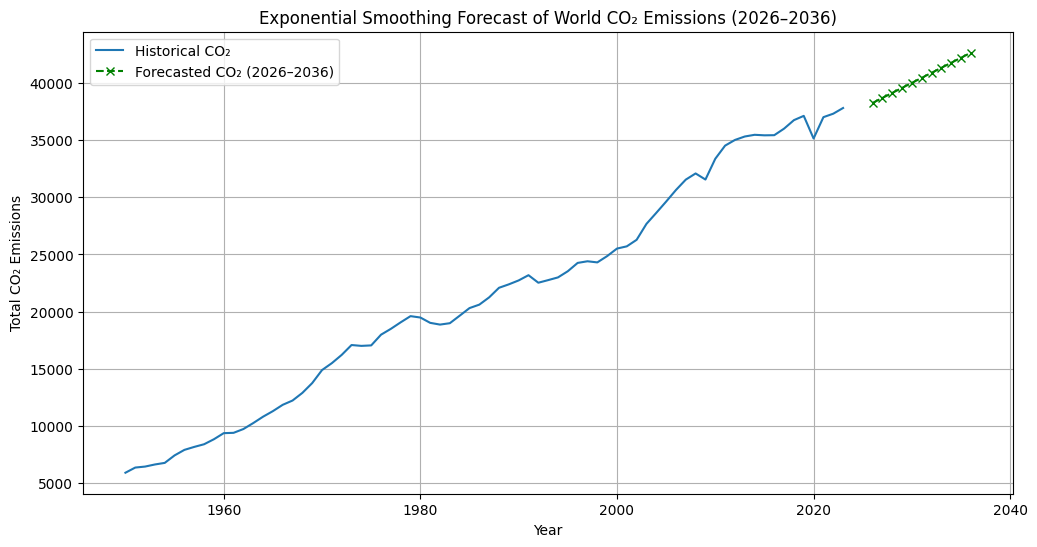

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Clean and set index
df_hw = df6[['year', 'co2']].dropna().copy()
df_hw = df_hw.groupby('year')['co2'].mean().reset_index()
df_hw.set_index('year', inplace=True)

# Fit model
model = ExponentialSmoothing(df_hw['co2'], trend='add', seasonal=None)
fit = model.fit()

# Forecast
forecast = fit.forecast(steps=11)
forecast_years = list(range(2026, 2037))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_hw.index, df_hw['co2'], label='Historical CO₂')
plt.plot(forecast_years, forecast, marker='x', linestyle='--', color='green', label='Forecasted CO₂ (2026–2036)')
plt.xlabel('Year')
plt.ylabel('Total CO₂ Emissions')
plt.title("Exponential Smoothing Forecast of World CO₂ Emissions (2026–2036)")
plt.grid(True)
plt.legend()
plt.show()
